In [15]:
import torch
import torch.nn as nn
import numpy as np
from unet import UNet
import matplotlib.pyplot as plt
import torchvision.ops as ops
import cv2 as cv

In [2]:
torch.cuda.set_device(0)
device = torch.device('cuda')
loss_function = nn.BCEWithLogitsLoss()

In [3]:
images = torch.tensor(np.load("images.npy"), dtype=torch.float32)
masks = torch.tensor(np.load("masks.npy"), dtype=torch.float32)

split = int(images.shape[0]*0.9)
train_images = images[:split]
train_labels = masks[:split]

val_images = images[split:]
val_labels = masks[split:]

print(train_labels.shape)
print(val_labels.shape)

torch.Size([1213, 224, 224])
torch.Size([135, 224, 224])


In [4]:
model = UNet(num_classes=1, in_channels=3, depth=5, merge_mode='concat')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
model.to(device)

UNet(
  (conv_final): Conv2d(64, 1, kernel_size=(1, 1), stride=(1, 1))
  (down_convs): ModuleList(
    (0): DownConv(
      (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): DownConv(
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (2): DownConv(
      (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (3): DownConv(
      (conv1): Conv2d(256, 512, kernel_size=(3, 

In [5]:
def val_loss():
	val_losses = []
	for i in range(val_images.shape[0]):
		val_losses.append(loss_function(model(val_images[i:i+1].permute(0, 3, 1, 2).to(device)).squeeze(), val_labels[i:i+1].to(device).squeeze()).item())
	return (sum(val_losses)/len(val_losses))

In [6]:
losses = []

In [7]:
n_epochs = 100
batch_size = 16

for epoch in range(n_epochs):
	permutation = torch.randperm(train_images.shape[0])
	for i in range(0, permutation.shape[0], batch_size):
		optimizer.zero_grad()

		indices = permutation[i:i+batch_size]
		x, y = train_images[indices], train_labels[indices]

		x = x.to(device)
		y = y.to(device)

		logits = model(x.permute(0, 3, 1, 2))
		loss = loss_function(logits.squeeze(), y.squeeze())
		losses.append(loss.item())
		
		loss.backward()
		optimizer.step()
	print(val_loss())

0.08629488059216076
0.06336295011418837
0.04659300511357961
0.03552045261970273
0.029420734872972525
0.02823919302749413
0.022310821042844542
0.01933532183369001
0.015834107667345693
0.015687125158944614
0.013119051477837342
0.012787806691118965
0.012044317533986435
0.01293804185051057
0.009761756165298048
0.012781374042646752
0.01056133140637367
0.010382456516984988
0.008667306006989546
0.008536700650842654
0.007645257957348669
0.009037987391153971
0.00725546071426598
0.006161351621806346
0.006165674405551895
0.007008723029004479
0.00557047343743896
0.006189739474750779
0.005221632476551113
0.00532514880221613
0.0061671662756621285
0.006544582747543852
0.005657928540474839
0.004808585146545536
0.0047890590210617695
0.004964154190383851
0.0050091470841801275
0.0046569825538123645
0.004666928970254958
0.0044624512101075165
0.004796778502943063
0.004985058422338356
0.0043475636298319804


KeyboardInterrupt: 

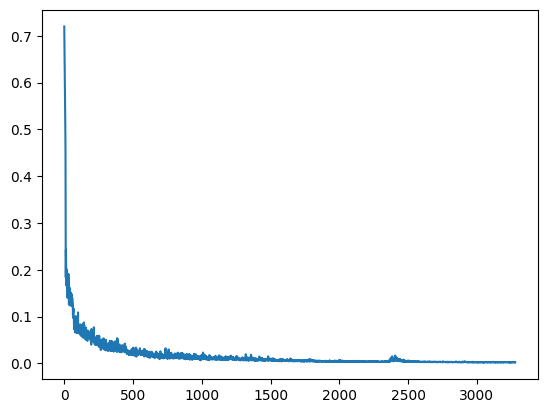

In [8]:
plt.plot(losses)

In [13]:
torch.save(model, "models/unet.pt")

In [10]:
test_images = torch.tensor(np.load("test_set.npy"), dtype=torch.float32)

In [34]:
cropped_images = []
for i in range(test_images.shape[0]):
	m = torch.sigmoid(model(test_images[i:i+1].permute(0, 3, 1, 2).to(device)).squeeze()).cpu().detach()
	m = torch.threshold(m, 0.1, 0)
	points = ops.masks_to_boxes(m.unsqueeze(0)).int().tolist()[0]
	img = test_images[i] * m.unsqueeze(2)
	img = img[points[1]:points[3], points[0]:points[2]]
	img = cv.resize(img.numpy(), (64, 64))
	cropped_images.append(img)
cropped_images = np.stack(cropped_images)
np.save("cropped_test_set.npy", cropped_images)